In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time
import random
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [2]:
def plot_confusion_matrix(y_true, y_pred, labels):
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()
  plt.show()

In [3]:
def classification_report_and_confusion_matrix(y_test, y_pred, labels):
  print(classification_report(y_test, y_pred, target_names=labels, zero_division=0, digits=3))
  plot_confusion_matrix(y_test, y_pred, labels)

In [4]:
train_df = pd.read_pickle('data/train.pkl')
val_df = pd.read_pickle('data/val.pkl')
test_df = pd.read_pickle('data/test.pkl')

# Seed

In [5]:
seed = 1337
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

Encode labels

In [6]:
train_y_raw = train_df['label']

In [7]:
label_encoder = LabelEncoder().fit(train_y_raw)

In [8]:
y_train = label_encoder.transform(train_y_raw)
y_val = label_encoder.transform(val_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Setup CV train dataset with predefined validation set

In [9]:
cv_train_df = pd.concat([train_df, val_df])

In [10]:
test_fold = np.concatenate((-np.ones(len(train_df)), np.zeros(len(val_df))))
ps = PredefinedSplit(test_fold)

# MultinomialNB Classifier

In [11]:
def test_mnb_pipelines(input_features_name, cv_train_df, train_df, test_df, n_error_cases=10):
  cv_X_train = cv_train_df[input_features_name]
  cv_y_train = label_encoder.transform(cv_train_df['label'])
  X_train = train_df[input_features_name]
  X_test = test_df[input_features_name]

  def grid_search_params_for_pipeline(pipeline):
    # grid search
    param_grid = {
        "vec__ngram_range": [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
        "cls__alpha": [0.001, 0.01, 0.1, 0.5, 0.8, 1, 1.2, 1.6, 2],
    }
    search = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=ps)
    search.fit(cv_X_train, cv_y_train)
    print(f'Best parameter (CV f1. score={search.best_score_}: {search.best_params_}')
    return search.best_estimator_


  def eval_mnb_pipeline(pipeline):
    # refit on full train dataset and time it
    t1 = time.perf_counter()
    pipeline.fit(X_train, y_train)
    t2 = time.perf_counter()
    print(f'MultinomialNB pipeline training time: {t2-t1}s')

    t1 = time.perf_counter()
    y_pred = pipeline.predict(X_test)
    t2 = time.perf_counter()
    print(f'MultinomialNB pipeline predict time: {t2-t1}s')
    classification_report_and_confusion_matrix(y_test, y_pred, label_encoder.classes_)

    # Show wrongly predicted samples
    incorrect_pred_idxs = np.arange(len(y_pred))[(y_pred != y_test)]
    for incorrect_id in incorrect_pred_idxs[:n_error_cases]:
      print(f'predicted: {label_encoder.classes_[y_pred[incorrect_id]]}, correct: {label_encoder.classes_[y_test[incorrect_id]]}, text: {test_df.iloc[incorrect_id]["text"]},\nlemmas: {X_test.iloc[incorrect_id]}')

  # CountVectorizer pipeline
  print('######### CountVectorizer MultinomialNB pipeline #########')
  pipeline = Pipeline([('vec', CountVectorizer(preprocessor=lambda x: ' '.join(x))), ('cls', MultinomialNB())])
  best_count_vec_pipeline = grid_search_params_for_pipeline(pipeline)
  eval_mnb_pipeline(best_count_vec_pipeline)

  # TfidfVectorizer pipeline
  print('######### TfidfVectorizer MultinomialNB pipeline #########')
  pipeline = Pipeline([('vec', TfidfVectorizer(preprocessor=lambda x: ' '.join(x))), ('cls', MultinomialNB())])
  best_tfidf_vec_pipeline = grid_search_params_for_pipeline(pipeline)
  eval_mnb_pipeline(best_tfidf_vec_pipeline)

## Lemmas without punctuation

######### CountVectorizer MultinomialNB pipeline #########
Best parameter (CV f1. score=0.9746004192322808: {'cls__alpha': 0.8, 'vec__ngram_range': (1, 3)}
MultinomialNB pipeline training time: 0.42004943900000313s
MultinomialNB pipeline predict time: 0.023442021000001034s
              precision    recall  f1-score   support

         ham      0.978     0.998     0.988       448
        spam      0.983     0.855     0.915        69

    accuracy                          0.979       517
   macro avg      0.981     0.926     0.951       517
weighted avg      0.979     0.979     0.978       517



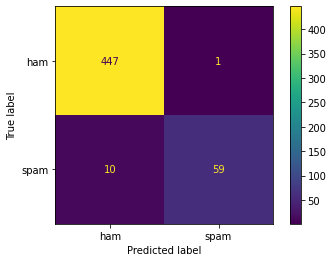

predicted: ham, correct: spam, text: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs),
lemmas: ['babe' 'u' 'want' 'I' 'do' 'not' 'u' 'baby' 'I' 'm' 'nasty' 'and' 'have'
 'a' 'thing' '4' 'filthyguy' 'fancy' 'a' 'rude' 'time' 'with' 'a' 'sexy'
 'bitch' 'how' 'about' 'we' 'go' 'slo' 'n' 'hard' 'Txt' 'XXX' 'slo(4msg']
predicted: ham, correct: spam, text: You can donate £2.50 to UNICEF's Asian Tsunami disaster support fund by texting DONATE to 864233. £2.50 will be added to your next bill,
lemmas: ['you' 'can' 'donate' '£' '2.50' 'to' 'UNICEF' "'s" 'Asian' 'Tsunami'
 'disaster' 'support' 'fund' 'by' 'texte' 'donate' 'to' '864233' '£'
 '2.50' 'will' 'be' 'add' 'to' 'your' 'next' 'bill']
predicted: ham, correct: spam, text: LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms,
lemmas: ['life' 'have' 'never' 

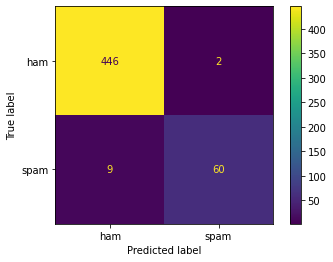

predicted: ham, correct: spam, text: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs),
lemmas: ['babe' 'u' 'want' 'I' 'do' 'not' 'u' 'baby' 'I' 'm' 'nasty' 'and' 'have'
 'a' 'thing' '4' 'filthyguy' 'fancy' 'a' 'rude' 'time' 'with' 'a' 'sexy'
 'bitch' 'how' 'about' 'we' 'go' 'slo' 'n' 'hard' 'Txt' 'XXX' 'slo(4msg']
predicted: ham, correct: spam, text: You can donate £2.50 to UNICEF's Asian Tsunami disaster support fund by texting DONATE to 864233. £2.50 will be added to your next bill,
lemmas: ['you' 'can' 'donate' '£' '2.50' 'to' 'UNICEF' "'s" 'Asian' 'Tsunami'
 'disaster' 'support' 'fund' 'by' 'texte' 'donate' 'to' '864233' '£'
 '2.50' 'will' 'be' 'add' 'to' 'your' 'next' 'bill']
predicted: ham, correct: spam, text: LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms,
lemmas: ['life' 'have' 'never' 

In [12]:
test_mnb_pipelines('lemmas_without_punct', cv_train_df, train_df, test_df)

## Lemmas without punctuation and stop words

######### CountVectorizer MultinomialNB pipeline #########
Best parameter (CV f1. score=0.979221092399823: {'cls__alpha': 0.8, 'vec__ngram_range': (1, 3)}
MultinomialNB pipeline training time: 0.22539829099999054s
MultinomialNB pipeline predict time: 0.017796087999997212s
              precision    recall  f1-score   support

         ham      0.982     0.996     0.989       448
        spam      0.968     0.884     0.924        69

    accuracy                          0.981       517
   macro avg      0.975     0.940     0.957       517
weighted avg      0.980     0.981     0.980       517



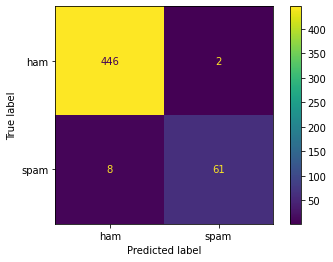

predicted: ham, correct: spam, text: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs),
lemmas: ['babe' 'u' 'want' 'not' 'u' 'baby' 'm' 'nasty' 'thing' '4' 'filthyguy'
 'fancy' 'rude' 'time' 'sexy' 'bitch' 'slo' 'n' 'hard' 'Txt' 'XXX'
 'slo(4msg']
predicted: ham, correct: spam, text: You can donate £2.50 to UNICEF's Asian Tsunami disaster support fund by texting DONATE to 864233. £2.50 will be added to your next bill,
lemmas: ['donate' '£' '2.50' 'UNICEF' 'Asian' 'Tsunami' 'disaster' 'support'
 'fund' 'texte' 'donate' '864233' '£' '2.50' 'add' 'bill']
predicted: ham, correct: spam, text: LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms,
lemmas: ['life' 'fun' 'great' 'come' 'truly' 'special' 'will' 'forget' 'enjoy'
 'gbp' 'sm']
predicted: ham, correct: spam, text: 22 days to kick off! For Euro2004 U

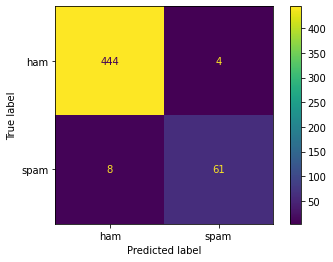

predicted: ham, correct: spam, text: Babe: U want me dont u baby! Im nasty and have a thing 4 filthyguys. Fancy a rude time with a sexy bitch. How about we go slo n hard! Txt XXX SLO(4msgs),
lemmas: ['babe' 'u' 'want' 'not' 'u' 'baby' 'm' 'nasty' 'thing' '4' 'filthyguy'
 'fancy' 'rude' 'time' 'sexy' 'bitch' 'slo' 'n' 'hard' 'Txt' 'XXX'
 'slo(4msg']
predicted: ham, correct: spam, text: You can donate £2.50 to UNICEF's Asian Tsunami disaster support fund by texting DONATE to 864233. £2.50 will be added to your next bill,
lemmas: ['donate' '£' '2.50' 'UNICEF' 'Asian' 'Tsunami' 'disaster' 'support'
 'fund' 'texte' 'donate' '864233' '£' '2.50' 'add' 'bill']
predicted: ham, correct: spam, text: LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms,
lemmas: ['life' 'fun' 'great' 'come' 'truly' 'special' 'will' 'forget' 'enjoy'
 'gbp' 'sm']
predicted: ham, correct: spam, text: 22 days to kick off! For Euro2004 U

In [13]:
test_mnb_pipelines('lemmas_without_puct_and_stop_words', cv_train_df, train_df, test_df)

# Notes/Observations
* Not big difference between filtering out stop words
  * stop words list tend to be very extensive and often can remove a lot of context so it's always a good idea to remove them but in our case with spacy it doesn't seem to affect the perfomance very much, on the other hand if we do remove them then our count vector vocab becomes smaller -> the vector is less sparse
* Similar perfomance on both `lemmas_without_punct` and `lemmas_without_puct_and_stop_words` features
  * CountVectorizer MultinomialNB pipeline on `lemmas_without_puct_and_stop_words` features has a slight edge
* Mostly fails on messages with sexual context and ham messages mentioning money/cash -> not surprising we have seen that those are very popular words in spam messages
* Overall solid performance